In [5]:
################################################################################################
# 
#       https://www.cnblogs.com/king-lps/p/8342452.html
# 
################################################################################################

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 24 10:00:24 2018
Paper: Siamese Neural Networks for One-shot Image Recognition
links: https://www.cnblogs.com/denny402/p/7520063.html
"""
import torch
from torch.autograd import Variable
import os
import random
import linecache
import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import PIL.ImageOps  
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

im_aug = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor()
])

class Config():
    root = '/home/lps/Spyder/data_faces/'
    txt_root = '/home/lps/Spyder/data_faces/train.txt'
    train_batch_size = 32
    train_number_epochs = 30

In [2]:

# Helper functions
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    


def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    

def convert(train=True):
    if(train):
        f=open(Config.txt_root, 'w')
        data_path=root+'/train/'
        if(not os.path.exists(data_path)):
            os.makedirs(data_path)
        for i in range(40):
              for j in range(10):
                    img_path = data_path+'s'+str(i+1)+'/'+str(j+1)+'.pgm'
                    f.write(img_path+' '+str(i)+'\n')      
        f.close()
        
#convert(True)

# ready the dataset, Not use ImageFolder as the author did
class MyDataset(Dataset):
      
      def __init__(self, txt, transform=None, target_transform=None, should_invert=False):
            
            self.transform = transform
            self.target_transform = target_transform
            self.should_invert = should_invert
            self.txt = txt

      def __getitem__(self, index):

            line = linecache.getline(self.txt, random.randint(1, self.__len__()))
            line.strip('\n')
            img0_list= line.split()
            should_get_same_class = random.randint(0,1) 
            if should_get_same_class:
                  while True:
                        img1_list = linecache.getline(self.txt, random.randint(1, self.__len__())).strip('\n').split()
                        if img0_list[1]==img1_list[1]:
                              break
            else:
                  img1_list = linecache.getline(self.txt, random.randint(1,self.__len__())).strip('\n').split()
            
            img0 = Image.open(img0_list[0])
            img1 = Image.open(img1_list[0])
            img0 = img0.convert("L")
            img1 = img1.convert("L")
        
            if self.should_invert:
                img0 = PIL.ImageOps.invert(img0)
                img1 = PIL.ImageOps.invert(img1)

            if self.transform is not None:
                img0 = self.transform(img0)
                img1 = self.transform(img1)
        
            return img0, img1 , torch.from_numpy(np.array([int(img1_list[1]!=img0_list[1])],dtype=np.float32))
    
      def __len__(self):
            fh = open(self.txt, 'r')
            num = len(fh.readlines())
            fh.close()
            return num

  
# Visualising some of the data
"""
train_data=MyDataset(txt = Config.txt_root, transform=transforms.ToTensor(), 
                     transform=transforms.Compose([transforms.Scale((100,100)),
                               transforms.ToTensor()], should_invert=False))
train_loader = DataLoader(dataset=train_data, batch_size=8, shuffle=True)
#it = iter(train_loader)
p1, p2, label = it.next()
example_batch = it.next()
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())
"""

# Neural Net Definition, Standard CNNs
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class SiameseNetwork(nn.Module):
      def __init__(self):
            super(SiameseNetwork, self).__init__()
            self.cnn1 = nn.Sequential(
                  nn.ReflectionPad2d(1),
                  nn.Conv2d(1, 4, kernel_size=3),
                  nn.ReLU(inplace=True),
                  nn.BatchNorm2d(4),
                  nn.Dropout2d(p=.2),
                  
                  nn.ReflectionPad2d(1),
                  nn.Conv2d(4, 8, kernel_size=3),
                  nn.ReLU(inplace=True),
                  nn.BatchNorm2d(8),
                  nn.Dropout2d(p=.2),
                      
                  nn.ReflectionPad2d(1),
                  nn.Conv2d(8, 8, kernel_size=3),
                  nn.ReLU(inplace=True),
                  nn.BatchNorm2d(8),
                  nn.Dropout2d(p=.2),
                  )
            
            self.fc1 = nn.Sequential(
                  nn.Linear(8*100*100, 500),
                  nn.ReLU(inplace=True),
                  
                  nn.Linear(500, 500),
                  nn.ReLU(inplace=True),
                  
                  nn.Linear(500, 5)
                  )

      def forward_once(self, x):
            output = self.cnn1(x)
            output = output.view(output.size()[0], -1)
            output = self.fc1(output)
            return output
      
      def forward(self, input1, input2):
             output1 = self.forward_once(input1)
             output2 = self.forward_once(input2)
             return output1, output2
       
      
# Custom Contrastive Loss
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive
  

class SiameseNetworkDataset():
    __epoch_size__ = 200

    def __init__(self,transform=None,should_invert=False):
        self.imageFolderDataset = []
        self.train_dataloader = []
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self):
        '''
        如果图像来自同一个类，标签将为0，否则为1
        '''
        img0_class = random.randint(0,40-1)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            temp = random.sample(list(range(0,10)), 2)
            img0_tuple = (self.imageFolderDataset[img0_class][temp[0]], img0_class)
            img1_tuple = (self.imageFolderDataset[img0_class][temp[1]], img0_class)
        else:
            img1_class = random.randint(0, 40 - 1)
            # 保证属于不同类别
            while img1_class == img0_class:
                img1_class = random.randint(0, 40 - 1)
            img0_tuple = (self.imageFolderDataset[img0_class][random.randint(0,9)], img0_class)
            img1_tuple = (self.imageFolderDataset[img1_class][random.randint(0,9)], img1_class)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        # 用以指定一种色彩模式, "L"8位像素，黑白
        # img0 = img0.convert("L")
        # img1 = img1.convert("L")

        # img0 = img0.resize((100,100),Image.BILINEAR)
        # img1 = img1.resize((100,100),Image.BILINEAR)

        if self.should_invert:
            # 二值图像黑白反转
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        # if self.transform is not None:
        #     # 不知道是做什么用的
        #     img0 = self.transform(img0)
        #     img1 = self.transform(img1)
        
        # return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        return img0, img1, should_get_same_class

    def att_face_data(self):
        ''' AT&T 数据集: 共40类, 每类十张图像 '''
        local = 'D:/MINE_FILE/dataSet/att_faces/'
        self.imageFolderDataset = []
        for i in range(1, 40 + 1):
            temp = []
            sub_floder = local + 's' + str(i) + '/'
            for j in range(1, 10 + 1):
                temp.append(sub_floder + str(j) + '.pgm')
            self.imageFolderDataset.append(temp)
        # 为数据集添加数据
        for i in range(self.__epoch_size__):
            img0, img1, label = self.__getitem__()
            self.train_dataloader.append((img0, img1, label))
            # print("\r" + 'Cnt: ' + str(i)  + '/' + str(self.__epoch_size__) + '[' +">>" * i + ']',end=' ')


start preparing the data...
finish preparing the data...
Epoch:0, step: 0 Current loss 0.041812311857938766
Epoch:0, step: 10 Current loss 23.113407135009766
Epoch:0, step: 20 Current loss 0.0
Epoch:0, step: 30 Current loss 20.654125213623047
Epoch:0, step: 40 Current loss 6.462148666381836
Epoch:0, step: 50 Current loss 8.581554412841797
Epoch:0, step: 60 Current loss 17.410934448242188
Epoch:0, step: 70 Current loss 0.0
Epoch:0, step: 80 Current loss 0.0
Epoch:0, step: 90 Current loss 8.39128303527832
Epoch:0, step: 100 Current loss 0.0
Epoch:0, step: 110 Current loss 0.0
Epoch:0, step: 120 Current loss 0.0
Epoch:0, step: 130 Current loss 11.210296630859375
Epoch:0, step: 140 Current loss 0.0
Epoch:0, step: 150 Current loss 0.0
Epoch:0, step: 160 Current loss 0.0
Epoch:0, step: 170 Current loss 0.0
Epoch:0, step: 180 Current loss 28.006492614746094
Epoch:0, step: 190 Current loss 0.05961867421865463
Epoch:1, step: 0 Current loss 7.634810924530029
Epoch:1, step: 10 Current loss 12.265

Epoch:8, step: 70 Current loss 2.7566847801208496
Epoch:8, step: 80 Current loss 2.665137767791748
Epoch:8, step: 90 Current loss 0.8411137461662292
Epoch:8, step: 100 Current loss 0.13916175067424774
Epoch:8, step: 110 Current loss 2.415860652923584
Epoch:8, step: 120 Current loss 2.3942313194274902
Epoch:8, step: 130 Current loss 0.09160804748535156
Epoch:8, step: 140 Current loss 1.1297482252120972
Epoch:8, step: 150 Current loss 0.3120373785495758
Epoch:8, step: 160 Current loss 0.0
Epoch:8, step: 170 Current loss 2.5226995944976807
Epoch:8, step: 180 Current loss 0.4375791549682617
Epoch:8, step: 190 Current loss 1.8438986539840698
Epoch:9, step: 0 Current loss 0.6852406859397888
Epoch:9, step: 10 Current loss 0.5781784057617188
Epoch:9, step: 20 Current loss 1.2554980516433716
Epoch:9, step: 30 Current loss 0.1307162344455719
Epoch:9, step: 40 Current loss 0.3204134702682495
Epoch:9, step: 50 Current loss 11.704116821289062
Epoch:9, step: 60 Current loss 2.8713159561157227
Epoch:

Epoch:16, step: 140 Current loss 0.01700361631810665
Epoch:16, step: 150 Current loss 0.012020903639495373
Epoch:16, step: 160 Current loss 0.0
Epoch:16, step: 170 Current loss 2.145998477935791
Epoch:16, step: 180 Current loss 0.08982978761196136
Epoch:16, step: 190 Current loss 0.0
Epoch:17, step: 0 Current loss 0.051992084830999374
Epoch:17, step: 10 Current loss 0.62171471118927
Epoch:17, step: 20 Current loss 0.0
Epoch:17, step: 30 Current loss 0.08655830472707748
Epoch:17, step: 40 Current loss 0.1732676774263382
Epoch:17, step: 50 Current loss 0.7616376876831055
Epoch:17, step: 60 Current loss 0.7044318318367004
Epoch:17, step: 70 Current loss 0.05219651013612747
Epoch:17, step: 80 Current loss 0.2010948657989502
Epoch:17, step: 90 Current loss 0.10768244415521622
Epoch:17, step: 100 Current loss 1.1025549173355103
Epoch:17, step: 110 Current loss 0.0
Epoch:17, step: 120 Current loss 0.0
Epoch:17, step: 130 Current loss 0.01823972538113594
Epoch:17, step: 140 Current loss 3.1889

Epoch:25, step: 80 Current loss 0.0
Epoch:25, step: 90 Current loss 0.0567781962454319
Epoch:25, step: 100 Current loss 0.0
Epoch:25, step: 110 Current loss 0.0
Epoch:25, step: 120 Current loss 0.0
Epoch:25, step: 130 Current loss 0.11563204228878021
Epoch:25, step: 140 Current loss 1.1844711303710938
Epoch:25, step: 150 Current loss 0.0
Epoch:25, step: 160 Current loss 0.0
Epoch:25, step: 170 Current loss 1.3925312757492065
Epoch:25, step: 180 Current loss 0.3584856390953064
Epoch:25, step: 190 Current loss 0.6785473823547363
Epoch:26, step: 0 Current loss 0.24942544102668762
Epoch:26, step: 10 Current loss 0.3114188313484192
Epoch:26, step: 20 Current loss 0.0
Epoch:26, step: 30 Current loss 0.010367071256041527
Epoch:26, step: 40 Current loss 0.14269550144672394
Epoch:26, step: 50 Current loss 0.304463267326355
Epoch:26, step: 60 Current loss 0.30856359004974365
Epoch:26, step: 70 Current loss 0.5155870914459229
Epoch:26, step: 80 Current loss 0.0
Epoch:26, step: 90 Current loss 0.1

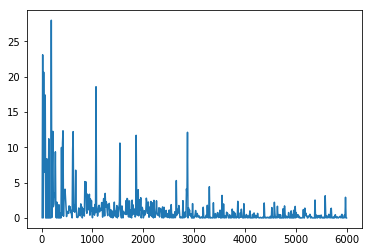

In [4]:
if __name__ == '__main__':
    # Training 
    # train_data = MyDataset(txt = Config.txt_root,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]), should_invert=False)
    # train_dataloader = DataLoader(dataset=train_data, shuffle=True, num_workers=2, batch_size = Config.train_batch_size)

    print('start preparing the data...')
    train_data = SiameseNetworkDataset()
    train_data.att_face_data()
    print('finish preparing the data...')

    # net = SiameseNetwork().cuda()
    net = SiameseNetwork()
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0005)

    counter = []
    loss_history =[]
    iteration_number =0

    for epoch in range(0, Config.train_number_epochs):
        for i, data in enumerate(train_data.train_dataloader, 0):
            img0, img1, label = data
            img0 = im_aug(img0)
            img1 = im_aug(img1)
            img0 = torch.unsqueeze(img0, dim=0).float()
            img1 = torch.unsqueeze(img1, dim=0).float()

            # img0, img1, label = Variable(img0).cuda(), Variable(img1).cuda(), Variable(label).cuda()
            # img0, img1, label = Variable(img0), Variable(img1), Variable(label)

            output1, output2 = net(img0, img1)
            optimizer.zero_grad()
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()
            
            if i%10 == 0:
                print("Epoch:{}, step: {} Current loss {}".format(epoch, i, loss_contrastive.data.item()))
                iteration_number += 10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.data.item())
    show_plot(counter, loss_history)

    # Total codes

In [16]:
# show_plot(counter, loss_history)

img_x, img_y, label = train_data.train_dataloader[0]

from torchvision.transforms import ToPILImage

img = ToPILImage()(img_x) #tensor转为PIL Image
img.show()



# plt.subplot(121), plt.imshow(img_x)
# plt.subplot(122), plt.imshow(img_y)
# plt.show()


TypeError: pic should be Tensor or ndarray. Got <class 'PIL.PpmImagePlugin.PpmImageFile'>.

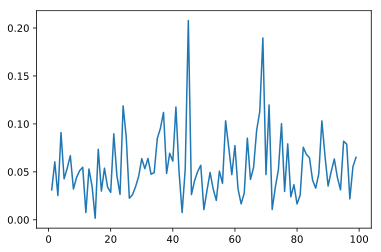

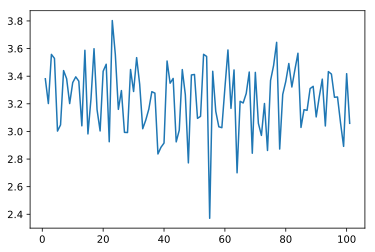

In [22]:
if __name__ == '__main__':

    # net = SiameseNetwork().cuda()
    net = SiameseNetwork()
    criterion = ContrastiveLoss()
    label0 = [0]
    loss0 = []
    label1 = [0]
    loss1 = []
    
    iteration_number =0
    for i, data in enumerate(train_data.train_dataloader, 0):
        img0, img1, label = data
        img0 = im_aug(img0)
        img1 = im_aug(img1)
        img0 = torch.unsqueeze(img0, dim=0).float()
        img1 = torch.unsqueeze(img1, dim=0).float()

        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        
        if label == 0:
            label0.append(label0[-1] + 1)
            loss0.append(loss_contrastive.data.item())
        else:
            label1.append(label1[-1] + 1)
            loss1.append(loss_contrastive.data.item())
    del label0[0]
    del label1[0]
    show_plot(label0, loss0)
    show_plot(label1, loss1)

In [17]:
%whos

Variable                Type                     Data/Info
----------------------------------------------------------
Config                  type                     <class '__main__.Config'>
ContrastiveLoss         type                     <class '__main__.ContrastiveLoss'>
DataLoader              type                     <class 'torch.utils.data.dataloader.DataLoader'>
Dataset                 type                     <class 'torch.utils.data.dataset.Dataset'>
F                       module                   <module 'torch.nn.functio<...>orch\\nn\\functional.py'>
Image                   module                   <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
MyDataset               type                     <class '__main__.MyDataset'>
PIL                     module                   <module 'PIL' from 'D:\\s<...>kages\\PIL\\__init__.py'>
SiameseNetwork          type                     <class '__main__.SiameseNetwork'>
SiameseNetworkDataset   type                     <class '